In [1]:
n_sub = spark.read.parquet('s3://adtech-ml-perf-ads-us-east-1-prod-v1/data/live_ads_inventory_forecasting/sub_num/').toPandas()

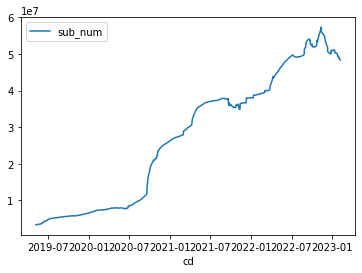

In [2]:
n_sub.sort_values('cd', ignore_index=True).plot(x='cd', y='sub_num');

In [5]:
df = n_sub.copy()
df.columns = ['y', 'ds']
df

,y,ds
0,24625690,2020-11-23
1,5421137,2019-08-26
2,37245973,2021-07-26
3,37223349,2021-07-23
4,49636237,2022-08-22
...,...,...
1366,35476732,2021-10-15
1367,9667898,2020-08-06
1368,53394403,2022-10-26
1369,6992665,2020-01-24


In [48]:
from glob import glob
import pandas as pd

def normalize(s):
    return ''.join(i for i in s if i.isalpha())

lst = []

for f in glob('valid_dates/*.json'):
    tour = f.split('/')[1].split('.')[0]
    days = pd.read_json(f, typ='series')
    lst.append(pd.DataFrame({
        'holiday': normalize(tour),
        'ds': days,
        'lower_window': 0,
        'upper_window': 0,
    }))

holidays = pd.concat(lst)
holidays

,holiday,ds,lower_window,upper_window
0,wc,2022-10-16,0,0
1,wc,2022-10-17,0,0
2,wc,2022-10-18,0,0
3,wc,2022-10-19,0,0
4,wc,2022-10-20,0,0
...,...,...,...,...
9,ac,2023-09-07,0,0
10,ac,2023-09-08,0,0
11,ac,2023-09-09,0,0
12,ac,2023-09-11,0,0


In [49]:
from prophet import Prophet
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='IN')
model=m.fit(df)

/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
02:24:17 - cmdstanpy - INFO - Chain [1] start processing
02:24:19 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1731,2024-02-01
1732,2024-02-02
1733,2024-02-03
1734,2024-02-04
1735,2024-02-05


In [51]:
m.train_holiday_names

0                                  wc
1                                 ipl
2                                 cwc
3                                  ac
4                        Republic Day
5                    Independence Day
6                      Gandhi Jayanti
7                              Diwali
8                                Holi
9                       Day of Ashura
10                             Mawlid
11                        Eid al-Fitr
12             Feast of the Sacrifice
13                     New Year's Day
14                        Palm Sunday
15                    Maundy Thursday
16                        Good Friday
17                      Easter Sunday
18                 Feast of Pentecost
19    Fest of St. Theresa of Calcutta
20        Feast of the Blessed Virgin
21                     All Saints Day
22                      All Souls Day
23                      Christmas Day
24                         Boxing Day
25               Feast of Holy Family
dtype: objec

/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


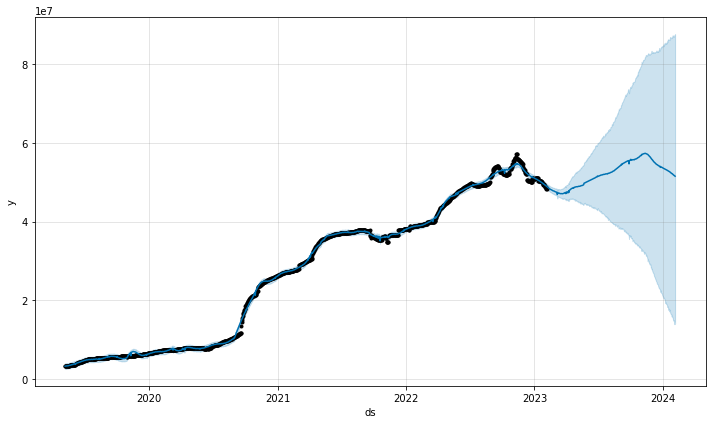

In [52]:
forecast = m.predict(future)
m.plot(forecast);

In [53]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints Day,All Saints Day_lower,All Saints Day_upper,All Souls Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-05-07,5.470143e+06,2.599701e+06,4.022158e+06,5.470143e+06,5.470143e+06,0.0,0.0,0.0,0.0,...,-10580.564155,-10580.564155,-10580.564155,-2.165427e+06,-2.165427e+06,-2.165427e+06,0.0,0.0,0.0,3.294136e+06
1,2019-05-08,5.463044e+06,2.601483e+06,3.990012e+06,5.463044e+06,5.463044e+06,0.0,0.0,0.0,0.0,...,-16848.514164,-16848.514164,-16848.514164,-2.154417e+06,-2.154417e+06,-2.154417e+06,0.0,0.0,0.0,3.291779e+06
2,2019-05-09,5.455945e+06,2.591512e+06,4.032569e+06,5.455945e+06,5.455945e+06,0.0,0.0,0.0,0.0,...,-15762.006067,-15762.006067,-15762.006067,-2.141922e+06,-2.141922e+06,-2.141922e+06,0.0,0.0,0.0,3.298261e+06
3,2019-05-10,5.448846e+06,2.629501e+06,4.024482e+06,5.448846e+06,5.448846e+06,0.0,0.0,0.0,0.0,...,5679.404247,5679.404247,5679.404247,-2.127800e+06,-2.127800e+06,-2.127800e+06,0.0,0.0,0.0,3.326726e+06
4,2019-05-11,5.441747e+06,2.549670e+06,4.007375e+06,5.441747e+06,5.441747e+06,0.0,0.0,0.0,0.0,...,4508.805583,4508.805583,4508.805583,-2.111948e+06,-2.111948e+06,-2.111948e+06,0.0,0.0,0.0,3.334308e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,2024-02-01,5.341649e+07,1.496024e+07,8.702670e+07,1.635544e+07,8.910731e+07,0.0,0.0,0.0,0.0,...,-15762.006067,-15762.006067,-15762.006067,-1.572878e+06,-1.572878e+06,-1.572878e+06,0.0,0.0,0.0,5.182785e+07
1732,2024-02-02,5.342361e+07,1.470255e+07,8.699108e+07,1.627679e+07,8.918779e+07,0.0,0.0,0.0,0.0,...,5679.404247,5679.404247,5679.404247,-1.656337e+06,-1.656337e+06,-1.656337e+06,0.0,0.0,0.0,5.177296e+07
1733,2024-02-03,5.343074e+07,1.394085e+07,8.741877e+07,1.609451e+07,8.926827e+07,0.0,0.0,0.0,0.0,...,4508.805583,4508.805583,4508.805583,-1.739913e+06,-1.739913e+06,-1.739913e+06,0.0,0.0,0.0,5.169534e+07
1734,2024-02-04,5.343787e+07,1.468424e+07,8.746331e+07,1.595522e+07,8.934875e+07,0.0,0.0,0.0,0.0,...,29487.263800,29487.263800,29487.263800,-1.823332e+06,-1.823332e+06,-1.823332e+06,0.0,0.0,0.0,5.164402e+07


/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)
/home/hadoop/.local/lib/python3.7/site-packages/prophet/hdays.py:209: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


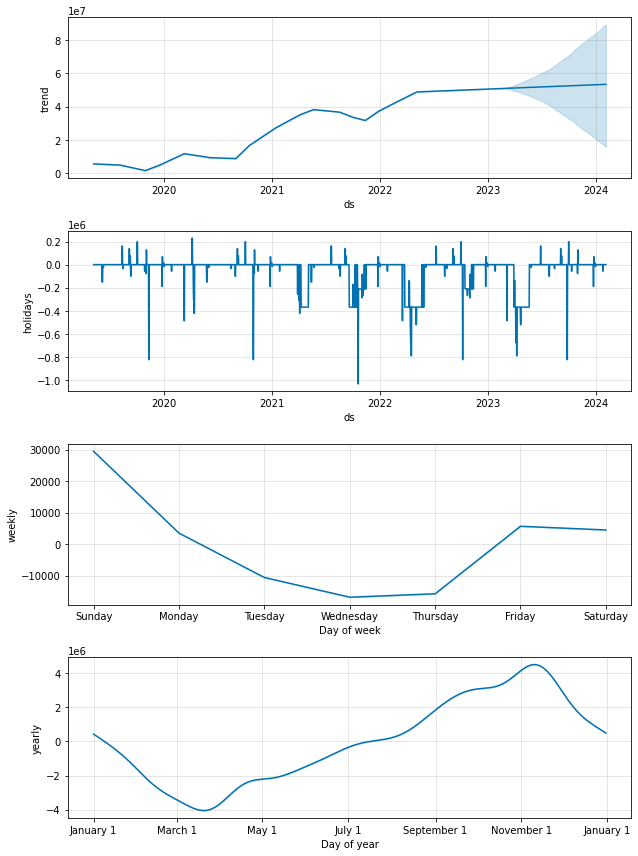

In [82]:
m.plot_components(forecast);

In [64]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [86]:
%%capture
t = cross_validation(m, initial='730 days', period='30 days', horizon = '365 days', parallel="processes")

06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:36 - cmdstanpy - INFO - Chain [1] done processing
06:24:37 - cmdstanpy - INFO - Chain [1] done processing
06:24:38 - cmdstanpy - INFO - Chain [1] start processing
06:24:38 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:41 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:44 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1] done processing
06:24:45 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:47 - cmdstanpy - INFO - Chain [1] start processing
06:24:47 - cmdstanpy - INFO - Chain [1

In [87]:
t

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-05-12,3.581054e+07,3.557697e+07,3.604541e+07,35621670,2021-05-11
1,2021-05-13,3.598709e+07,3.575139e+07,3.619589e+07,35664276,2021-05-11
2,2021-05-14,3.610829e+07,3.584716e+07,3.633849e+07,35705775,2021-05-11
3,2021-05-15,3.615763e+07,3.591842e+07,3.638485e+07,35751415,2021-05-11
4,2021-05-16,3.627645e+07,3.603530e+07,3.652795e+07,35787369,2021-05-11
...,...,...,...,...,...,...
3645,2023-02-01,4.769891e+07,1.246989e+07,8.585668e+07,48877838,2022-02-05
3646,2023-02-02,4.770526e+07,1.209989e+07,8.570614e+07,48798333,2022-02-05
3647,2023-02-03,4.774297e+07,1.206559e+07,8.618049e+07,48470236,2022-02-05
3648,2023-02-04,4.774894e+07,1.161034e+07,8.608745e+07,48397451,2022-02-05


In [92]:
t.cutoff.drop_duplicates()

0      2021-05-11
365    2021-06-10
730    2021-07-10
1095   2021-08-09
1460   2021-09-08
1825   2021-10-08
2190   2021-11-07
2555   2021-12-07
2920   2022-01-06
3285   2022-02-05
Name: cutoff, dtype: datetime64[ns]

In [93]:
met = performance_metrics(t)
met

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.651875e+12,1.910988e+06,1.317030e+06,0.035782,0.018252,0.035713,0.397260
1,38 days,3.876815e+12,1.968963e+06,1.365408e+06,0.037071,0.020080,0.037009,0.393151
2,39 days,4.107035e+12,2.026582e+06,1.413484e+06,0.038355,0.021341,0.038296,0.391781
3,40 days,4.333796e+12,2.081777e+06,1.459023e+06,0.039570,0.022734,0.039514,0.394521
4,41 days,4.556809e+12,2.134668e+06,1.502688e+06,0.040734,0.024640,0.040679,0.395890
...,...,...,...,...,...,...,...,...
324,361 days,2.078585e+14,1.441730e+07,1.251075e+07,0.252202,0.184333,0.252645,1.000000
325,362 days,2.080048e+14,1.442237e+07,1.248710e+07,0.251485,0.184299,0.252052,1.000000
326,363 days,2.081206e+14,1.442639e+07,1.246075e+07,0.250723,0.184299,0.251408,1.000000
327,364 days,2.083096e+14,1.443294e+07,1.243624e+07,0.249991,0.184299,0.250794,1.000000


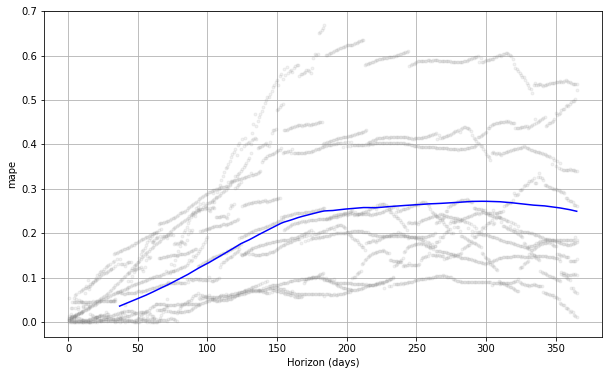

In [94]:
plot_cross_validation_metric(t, metric='mape');

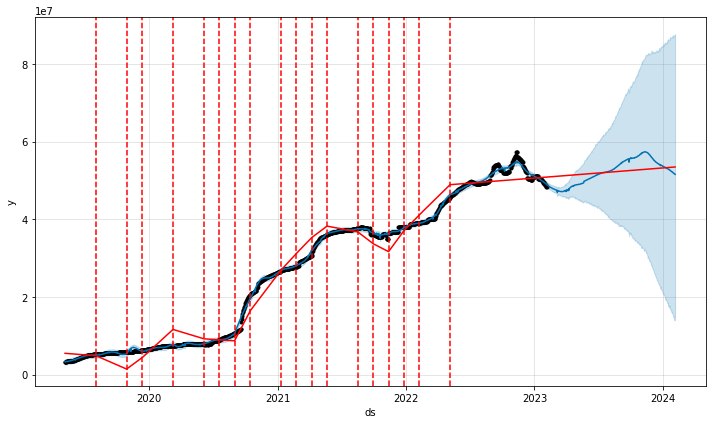

In [98]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

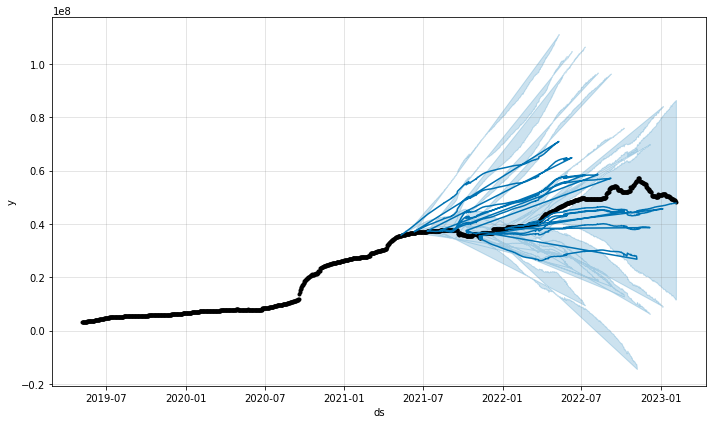

In [104]:
m.plot(t);

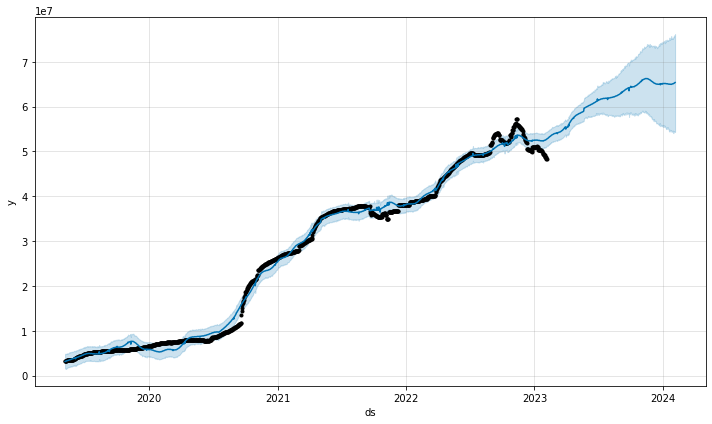

In [108]:
m2 = Prophet(holidays=holidays, changepoint_prior_scale=0.01)
m2.add_country_holidays(country_name='IN')
model2=m2.fit(df)
forecast2 = m2.predict(future)
m2.plot(forecast2);q

In [ ]:
plot_cross_validation_metric(cross_validation(m2, initial='730 days', period='30 days', horizon = '365 days', parallel="processes"), metric='mape');

In [ ]:
plot_cross_validation_metric(cross_validation(m3, initial='730 days', period='30 days', horizon = '365 days', parallel="processes"), metric='mape');

In [106]:
holidays2=pd.read_csv('valid_dates/tournament_holidays.csv')
holidays2

,ds,holiday,lower_window,upper_window
0,2019-05-08,ipl,0,0
1,2019-05-10,ipl,0,0
2,2019-05-30,world cup,0,0
3,2019-05-31,world cup,0,0
4,2019-06-01,world cup,0,0
...,...,...,...,...
444,2023-11-22,world cup,0,0
445,2023-11-23,world cup,0,0
446,2023-11-24,world cup,0,0
447,2023-11-25,world cup,0,0


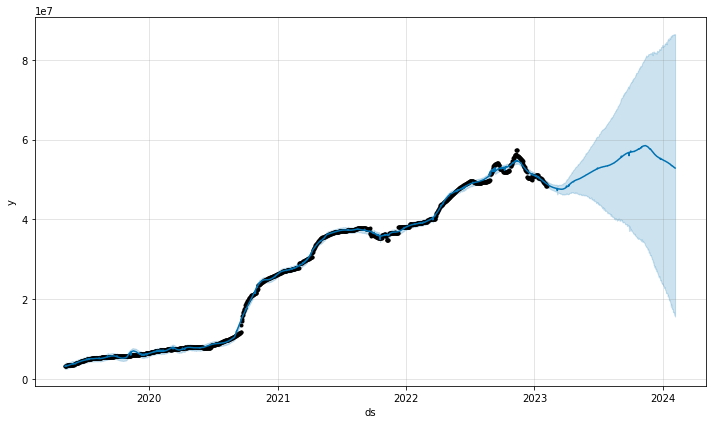

In [109]:
m3 = Prophet(holidays=holidays2)
m3.add_country_holidays(country_name='IN')
model3=m3.fit(df)
forecast3 = m3.predict(future)
m3.plot(forecast3);

In [110]:
m3.train_holiday_names

0          ipl                       
1          world cup                 
2          west indies tour india    
3          australia tour of india   
4          india tour of new zealand 
5          england tour of india     
6          west indies tour of india 
7          south africa tour of india
8          asia cup                  
9          sri lanka tour of india   
10         new zealand tour of india 
11                       Republic Day
12                   Independence Day
13                     Gandhi Jayanti
14                             Diwali
15                               Holi
16                      Day of Ashura
17                             Mawlid
18                        Eid al-Fitr
19             Feast of the Sacrifice
20                     New Year's Day
21                        Palm Sunday
22                    Maundy Thursday
23                        Good Friday
24                      Easter Sunday
25                 Feast of Pentecost
26    Fest o

In [113]:
holidays2

,ds,holiday,lower_window,upper_window
0,2019-05-08,ipl,0,0
1,2019-05-10,ipl,0,0
2,2019-05-30,world cup,0,0
3,2019-05-31,world cup,0,0
4,2019-06-01,world cup,0,0
...,...,...,...,...
444,2023-11-22,world cup,0,0
445,2023-11-23,world cup,0,0
446,2023-11-24,world cup,0,0
447,2023-11-25,world cup,0,0
